In [86]:
!export NEPTUNE_API_TOKEN="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiMzk3ODRlOTktYjU5NC00MzE3LTg5MzMtM2E5NjUyMmQ2ODliIn0="

In [87]:
import pandas as pd
from pathlib import Path
import time
from tqdm.notebook import tqdm
import numpy as np
import neptune

In [2]:
args = {}
args['data_folder'] = './Data'
args['data_filename'] = 'full_data_2014to2021.pkl'
args['summarize_n_games']= 5
args['columns_to_summarize']=['Team', 'Pace', 'eFG%', 'TOV%', 'ORB%', 'FT/FGA', 'ORtg']
args['summarize_method']='mean'

args['home_columns_to_summarize']=[column + '_'+'home' for column in args['columns_to_summarize']]
args['visitor_columns_to_summarize']=[column + '_'+'visitor' for column in args['columns_to_summarize']]
args['processed_dataset_filename']= f"ProcessedDataset_TeamBasis_{args['summarize_method']}_Past{args['summarize_n_games']}Games"

args['random_state']=248 # RIP Kobe

In [3]:
data_folder = Path(args['data_folder'])
assert data_folder.exists()

# Read Raw Data

In [135]:
dataset_df = pd.read_pickle(data_folder/args['data_filename'])
dataset_df.head()

,DATE,VISITOR,VISITOR_PTS,HOME,HOME_PTS,boxscores_url,game_id,Team_home,Pace_home,eFG%_home,...,ORB%_home,FT/FGA_home,ORtg_home,Team_visitor,Pace_visitor,eFG%_visitor,TOV%_visitor,ORB%_visitor,FT/FGA_visitor,ORtg_visitor
0,2013-10-29,ORL,87,IND,97,https://www.basketball-reference.com/boxscores/201310290IND.html,201310290IND,IND,95.0,0.528,...,27.8,0.310,102.1,ORL,95.0,0.435,14.9,27.7,0.065,91.6
1,2013-10-29,CHI,95,MIA,107,https://www.basketball-reference.com/boxscores/201310290MIA.html,201310290MIA,MIA,97.1,0.590,...,14.3,0.306,110.2,CHI,97.1,0.464,16.2,23.9,0.217,97.9
2,2013-10-29,LAC,103,LAL,116,https://www.basketball-reference.com/boxscores/201310290LAL.html,201310290LAL,LAL,100.4,0.527,...,37.5,0.194,115.6,LAC,100.4,0.542,14.7,22.7,0.157,102.6
3,2013-10-30,BRK,94,CLE,98,https://www.basketball-reference.com/boxscores/201310300CLE.html,201310300CLE,CLE,92.3,0.446,...,36.4,0.274,106.2,BRK,92.3,0.457,13.9,22.0,0.232,101.8
4,2013-10-30,BOS,87,TOR,93,https://www.basketball-reference.com/boxscores/201310300TOR.html,201310300TOR,TOR,91.5,0.471,...,42.2,0.140,101.6,BOS,91.5,0.508,21.8,19.4,0.303,95.1


In [137]:
# convert string columns to numeric columns
for column in ['VISITOR_PTS','HOME_PTS']:
    dataset_df[column] = pd.to_numeric(dataset_df[column])

In [138]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8743 entries, 0 to 8742
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   DATE            8743 non-null   datetime64[ns]
 1   VISITOR         8743 non-null   object        
 2   VISITOR_PTS     8743 non-null   float64       
 3   HOME            8743 non-null   object        
 4   HOME_PTS        8743 non-null   float64       
 5   boxscores_url   8743 non-null   object        
 6   game_id         8743 non-null   object        
 7   Team_home       8743 non-null   object        
 8   Pace_home       8743 non-null   float64       
 9   eFG%_home       8743 non-null   float64       
 10  TOV%_home       8743 non-null   float64       
 11  ORB%_home       8743 non-null   float64       
 12  FT/FGA_home     8743 non-null   float64       
 13  ORtg_home       8743 non-null   float64       
 14  Team_visitor    8743 non-null   object        
 15  Pace

In [141]:
dataset_df.columns

Index(['DATE', 'VISITOR', 'VISITOR_PTS', 'HOME', 'HOME_PTS', 'boxscores_url',
       'game_id', 'Team_home', 'Pace_home', 'eFG%_home', 'TOV%_home',
       'ORB%_home', 'FT/FGA_home', 'ORtg_home', 'Team_visitor', 'Pace_visitor',
       'eFG%_visitor', 'TOV%_visitor', 'ORB%_visitor', 'FT/FGA_visitor',
       'ORtg_visitor', 'TOTAL_PTS', 'HOME_VISITOR_PTS_DIFF', 'HOME_WIN'],
      dtype='object')

In [140]:
dataset_df['TOTAL_PTS'] = dataset_df['VISITOR_PTS']+dataset_df['HOME_PTS']
dataset_df['HOME_VISITOR_PTS_DIFF'] = dataset_df['HOME_PTS']-dataset_df['VISITOR_PTS']
dataset_df['HOME_WIN'] = (dataset_df['HOME_VISITOR_PTS_DIFF']>0)

In [142]:
dataset_df.to_excel(data_folder/'dataset.xlsx',index=False)

# Models

## Team based - simple average of past xx games


### Data Processing

In [ ]:
# get most recent x games data as training data
# test on 2021 data
    # sort by dates
    # iterate rows
    # get current index
    # from current index, go backwards index until found previous X games
        # if out of index before fetching X games, stop and continue (give up predicting this game)
    # if HOME or VISITOR equals to current row HOME, then get that row
    # save into a dictionary, key is game_id
    # transform as data frame, and join with the full data
# average
# 2 teams, concatenate to the same row
# predict

In [181]:
def strip_col_suffix(df):
    """
    strip the '_home' or '_visitor' suffix from the stats columns, using args
    """
    rename_dict = {old_col:new_col for old_col,new_col in zip(args['home_columns_to_summarize']+args['visitor_columns_to_summarize'],args['columns_to_summarize']*2)}
    return df.rename(columns=rename_dict)

def get_previous_games(curr_row_index,team_name,dataset_df:pd.DataFrame,previous_n=args['summarize_n_games'])->list:
    """
    return a list of pandas dataframes of previous of games, regardless of home or away.
    """
    previous_games = []
    # start iterating previous games
    for index in range(curr_row_index-1,-1,-1):
        try:
            # if home team matches
            if (dataset_df.loc[index]['HOME']==team_name):
                previous_game=dataset_df.loc[[index]][args['home_columns_to_summarize']]
                previous_games.append(strip_col_suffix(previous_game))
            # if visitor team matches
            if (dataset_df.loc[index]['VISITOR']==team_name):
                previous_game=dataset_df.loc[[index]][args['visitor_columns_to_summarize']]
                previous_games.append(strip_col_suffix(previous_game))
            # stop when we have enough games
            if len(previous_games)==previous_n:
                break
        except Exception as exc:
            print(exc)
    if len(previous_games)<args['summarize_n_games']:
        raise ValueError(f"Less than {args['summarize_n_games']} previous games.")
    # return a list of dataframes
    return previous_games

def summarize_previous_games(curr_row_index,team_name,original_df,previous_n=args['summarize_n_games'],summarize_method=args['summarize_method'],summarize_func=None)->pd.DataFrame:
    """
    calculate previous games' stats using `method`
    `previous_n`: number of previous games
    `summarize_method`: method to summarize prevous games
    """

    previous_games = get_previous_games(curr_row_index,team_name,original_df,previous_n)
    # concat return dataframes into one dataframe
    previous_games = pd.concat(previous_games)
    if summarize_func:
        return summarize_func(previous_games)
    if summarize_method == 'mean':
        return np.mean(previous_games,axis=0)
    if summarize_method == 'median':
            return np.median(previous_games,axis=0)

In [147]:
#TODO: use dataclass
dataset_df = dataset_df.sort_values(by='DATE').reset_index(drop=True)
games_summaries=[]
bad_index=[]
for index,row in tqdm(dataset_df.iterrows(),total=dataset_df.shape[0]):
    try:
        # home team summary
        summarized_home = summarize_previous_games(index, row['HOME'],dataset_df, args['summarize_n_games']).to_dict()
        summarized_home['Team'] = row['HOME']
        summarized_home['game_id'] = row['game_id']
        games_summaries.append(summarized_home)

        # visitor team summary
        summarized_visitor = summarize_previous_games(index, row['VISITOR'],dataset_df, args['summarize_n_games']).to_dict()
        summarized_visitor['Team'] = row['VISITOR']
        summarized_visitor['game_id'] = row['game_id']
        games_summaries.append(summarized_visitor)
    except Exception as exc:
        print(f"bad index {index}, error: {exc}")
        print('-'*100)
        bad_index.append(index)

    

bad index 0, error: Less than 5 previous games.
----------------------------------------------------------------------------------------------------
bad index 1, error: Less than 5 previous games.
----------------------------------------------------------------------------------------------------
bad index 2, error: Less than 5 previous games.
----------------------------------------------------------------------------------------------------
bad index 3, error: Less than 5 previous games.
----------------------------------------------------------------------------------------------------
bad index 4, error: Less than 5 previous games.
----------------------------------------------------------------------------------------------------
bad index 5, error: Less than 5 previous games.
----------------------------------------------------------------------------------------------------
bad index 6, error: Less than 5 previous games.
----------------------------------------------------------

In [150]:
len(games_summaries)

,Pace,eFG%,TOV%,ORB%,FT/FGA,ORtg,Team,game_id
0,96.70,0.5558,16.98,32.24,0.3586,113.12,HOU,201311070HOU
1,100.26,0.4738,12.98,20.76,0.1930,100.50,LAL,201311070HOU
2,92.82,0.5738,15.48,19.00,0.2518,113.12,MIA,201311070MIA
3,98.74,0.5342,12.76,27.82,0.2716,114.66,LAC,201311070MIA
4,93.20,0.5100,16.92,23.78,0.2526,102.48,IND,201311080IND
...,...,...,...,...,...,...,...,...
17321,97.04,0.5358,9.56,23.78,0.1576,117.48,POR,202102020WAS
17322,98.14,0.5526,13.78,24.12,0.2270,114.60,IND,202102020IND
17323,99.72,0.5676,9.98,24.40,0.1314,119.22,MEM,202102020IND
17324,95.96,0.5460,10.72,29.58,0.2560,122.54,UTA,202102020UTA


games_summaries_df = pd.DataFrame(games_summaries)
games_summaries_df

In [ ]:
temp_home = pd.merge(dataset_df[['DATE','VISITOR', 'VISITOR_PTS', 'HOME', 'HOME_PTS', 'boxscores_url','game_id']],games_summaries_df,left_on=['game_id','HOME'],right_on=['game_id','Team'])
processed_dataset=pd.merge(temp_home,games_summaries_df,left_on=['game_id','VISITOR'],right_on=['game_id','Team'],suffixes=('_home','_visitor'))
processed_dataset['TOTAL_PTS'] = processed_dataset['VISITOR_PTS']+processed_dataset['HOME_PTS']
processed_dataset['HOME_VISITOR_PTS_DIFF'] = processed_dataset['HOME_PTS']-processed_dataset['VISITOR_PTS']
processed_dataset['HOME_WIN'] = (processed_dataset['HOME_VISITOR_PTS_DIFF']>0)

In [206]:
processed_dataset



,DATE,VISITOR,VISITOR_PTS,HOME,HOME_PTS,boxscores_url,game_id,Pace_home,eFG%_home,TOV%_home,...,Pace_visitor,eFG%_visitor,TOV%_visitor,ORB%_visitor,FT/FGA_visitor,ORtg_visitor,Team_visitor,TOTAL_PTS,HOME_VISITOR_PTS_DIFF,HOME_WIN
0,2013-11-07,LAL,99.0,HOU,98.0,https://www.basketball-reference.com/boxscores...,201311070HOU,96.70,0.5558,16.98,...,100.26,0.4738,12.98,20.76,0.1930,100.50,LAL,197.0,-1.0,0
1,2013-11-07,LAC,97.0,MIA,102.0,https://www.basketball-reference.com/boxscores...,201311070MIA,92.82,0.5738,15.48,...,98.74,0.5342,12.76,27.82,0.2716,114.66,LAC,199.0,5.0,1
2,2013-11-08,TOR,84.0,IND,91.0,https://www.basketball-reference.com/boxscores...,201311080IND,93.20,0.5100,16.92,...,89.96,0.4732,13.72,32.76,0.2260,104.62,TOR,175.0,7.0,1
3,2013-11-08,BOS,91.0,ORL,89.0,https://www.basketball-reference.com/boxscores...,201311080ORL,96.76,0.5240,14.96,...,91.54,0.4862,18.10,24.24,0.2266,97.76,BOS,180.0,-2.0,0
4,2013-11-08,CLE,79.0,PHI,94.0,https://www.basketball-reference.com/boxscores...,201311080PHI,102.72,0.5140,16.50,...,94.72,0.4448,13.94,25.66,0.1854,96.16,CLE,173.0,15.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8656,2021-02-02,BOS,111.0,GSW,107.0,https://www.basketball-reference.com/boxscores...,202102020GSW,101.74,0.5562,12.96,...,98.22,0.5504,11.38,24.42,0.1682,115.90,BOS,218.0,-4.0,0
8657,2021-02-02,LAC,120.0,BRK,124.0,https://www.basketball-reference.com/boxscores...,202102020BRK,100.88,0.6076,10.54,...,96.04,0.5378,9.60,21.96,0.1972,117.08,LAC,244.0,4.0,1
8658,2021-02-02,POR,132.0,WAS,121.0,https://www.basketball-reference.com/boxscores...,202102020WAS,102.34,0.4752,11.16,...,97.04,0.5358,9.56,23.78,0.1576,117.48,POR,253.0,-11.0,0
8659,2021-02-02,MEM,116.0,IND,134.0,https://www.basketball-reference.com/boxscores...,202102020IND,98.14,0.5526,13.78,...,99.72,0.5676,9.98,24.40,0.1314,119.22,MEM,250.0,18.0,1


In [207]:
# TODO: automatically populate dataset name, model name
processed_dataset.to_pickle(data_folder/(args['processed_dataset_filename']+'.pkl'))

# Generate Training/Validation/Test Data

In [4]:
# import libraries
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from dtreeviz.trees import *

/opt/conda/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370156314/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [5]:
# load the processed data
teamstats = pd.read_pickle(data_folder/(args['processed_dataset_filename']+'.pkl'))
teamstats = add_datepart(teamstats, 'DATE')
teamstats.columns

Index(['VISITOR', 'VISITOR_PTS', 'DATEWeek', 'HOME', 'HOME_PTS',
       'boxscores_url', 'game_id', 'Pace_home', 'eFG%_home', 'TOV%_home',
       'ORB%_home', 'FT/FGA_home', 'ORtg_home', 'Team_home', 'Pace_visitor',
       'eFG%_visitor', 'TOV%_visitor', 'ORB%_visitor', 'FT/FGA_visitor',
       'ORtg_visitor', 'Team_visitor', 'TOTAL_PTS', 'HOME_VISITOR_PTS_DIFF',
       'HOME_WIN', 'DATEYear', 'DATEMonth', 'DATEDay', 'DATEDayofweek',
       'DATEDayofyear', 'DATEIs_month_end', 'DATEIs_month_start',
       'DATEIs_quarter_end', 'DATEIs_quarter_start', 'DATEIs_year_end',
       'DATEIs_year_start', 'DATEElapsed'],
      dtype='object')

In [7]:
# teamstats['DRtg_home']=100
# teamstats['DRtg_visitor']=100

In [7]:
# set what are dependent variables, what are independent variables
args['dep_variable'] = ['HOME_VISITOR_PTS_DIFF']
args['ind_variable'] = ['Pace_home', 'eFG%_home', 'TOV%_home', 'ORB%_home','FT/FGA_home', 'ORtg_home', 
                        'Pace_visitor','eFG%_visitor','TOV%_visitor', 'ORB%_visitor', 'FT/FGA_visitor', 'ORtg_visitor']

In [8]:
other_idx,test_idx = train_test_split(list(teamstats.index),test_size=0.1,random_state=args['random_state'])
test_set = teamstats.loc[test_idx,args['ind_variable']+args['dep_variable']].copy()
# don't want to mix non-test set with training set, therefore "other_set"
other_set = teamstats.loc[other_idx,args['ind_variable']+args['dep_variable']].copy()
train_idx,valid_idx = train_test_split(list(other_set.reset_index(drop=True).index),test_size=0.2,random_state=args['random_state'])
[len(idx) for idx in [train_idx,valid_idx,test_idx]]

[6235, 1559, 867]

In [15]:
# split continuous variables and categorical variabls
cont_var, cat_var=cont_cat_split(other_set,1,dep_var=args['dep_variable'])
print(cont_var,cat_var)

['Pace_home', 'eFG%_home', 'TOV%_home', 'ORB%_home', 'FT/FGA_home', 'ORtg_home', 'Pace_visitor', 'eFG%_visitor', 'TOV%_visitor', 'ORB%_visitor', 'FT/FGA_visitor', 'ORtg_visitor'] []


In [17]:
# return a tabular object
to=TabularPandas(other_set,cat_names=cat_var,cont_names=cont_var,
                 y_names=args['dep_variable'],splits=(train_idx,valid_idx))
len(to.train),len(to.valid)

(6235, 1559)

In [19]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y
print(len(xs))
print(len(valid_xs))

6235
1559


# Initialize Neptune to Record Experiments

In [114]:
# select project
neptune.init(project_qualified_name='jjnotjimmyjohn/NBA-Score-Prediction',api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiMzk3ODRlOTktYjU5NC00MzE3LTg5MzMtM2E5NjUyMmQ2ODliIn0=")
# export NEPTUNE_API_TOKEN="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiMzk3ODRlOTktYjU5NC00MzE3LTg5MzMtM2E5NjUyMmQ2ODliIn0="

Project(jjnotjimmyjohn/NBA-Score-Prediction)

# Decision Tree

In [65]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
import scipy.stats as stats
from sklearn.metrics import SCORERS

In [74]:
# parameters distribution to randomized search
dt_params_dist={
    'min_samples_split':[5,10,15,20],
    'min_samples_leaf':[10,20,30,40,60],
    'max_features':[0.5,0.6,0.7,0.8,0.9],
}
# base model
base_model = DecisionTreeRegressor(criterion='mae',random_state=args['random_state'])

In [75]:
model = RandomizedSearchCV(base_model,dt_params_dist,n_iter=90,n_jobs=6,
                                   cv=8,verbose=5,return_train_score=True,refit=True)
model.fit(xs, y)

Fitting 8 folds for each of 90 candidates, totalling 720 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    2.2s
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:   28.9s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done 636 tasks      | elapsed:  3.8min
[Parallel(n_jobs=6)]: Done 720 out of 720 | elapsed:  4.4min finished


RandomizedSearchCV took 0.00 seconds for 75 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.032 (std: 0.042)
Parameters: {'min_samples_split': 15, 'min_samples_leaf': 60, 'max_features': 0.7}

Model with rank: 1
Mean validation score: -0.032 (std: 0.042)
Parameters: {'min_samples_split': 5, 'min_samples_leaf': 60, 'max_features': 0.7}

Model with rank: 1
Mean validation score: -0.032 (std: 0.042)
Parameters: {'min_samples_split': 10, 'min_samples_leaf': 60, 'max_features': 0.7}



In [88]:
print(mean_absolute_error(y,model.predict(xs)))
print(mean_absolute_error(valid_y,model.predict(valid_xs)))

10.103769045709702
11.475304682488774


In [122]:
# create experiment
# neptune.set_project('jjnotjimmyjohn/NBA-Score-Prediction')
neptune.create_experiment(name='TeamBasedModel',description='',params=model.get_params())
neptune.append_tag(f'summarize_past_games')
neptune.append_tag(f'decision_tree')
neptune.append_tag(f'randomized_search_cv')
neptune.log_metric('training_error', mean_absolute_error(y,model.predict(xs)))
neptune.log_metric('validation_error', mean_absolute_error(valid_y,model.predict(valid_xs)))
neptune.log_text('best_model', str(model.best_estimator_))
for key,value in args.items():
    neptune.set_property(key,value)
neptune.stop()

psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/jjnotjimmyjohn/NBA-Score-Prediction/e/NBAS-3


# Randome Forest

In [209]:
def rf(xs, y, n_estimators=1000, max_samples=len(xs),max_features=0.7, min_samples_leaf=75, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
    max_samples=max_samples, max_features=max_features,
    min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y) 

In [211]:
m = rf(xs, y)
print("training error: ",m_rmse(m, xs, y))
print("validation error: ",m_rmse(m, valid_xs, valid_y))

training error:  12.9126
validation error:  13.751252


In [213]:
m.feature_importances_

array([0.04076792, 0.07589832, 0.04150054, 0.04504504, 0.04060112,
       0.26472846, 0.04136464, 0.13583104, 0.05517833, 0.04676356,
       0.03597419, 0.17634684])

In [212]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [214]:
fi = rf_feat_importance(m, xs)
fi

,cols,imp
5,ORtg_home,0.264728
11,ORtg_visitor,0.176347
7,eFG%_visitor,0.135831
1,eFG%_home,0.075898
8,TOV%_visitor,0.055178
9,ORB%_visitor,0.046764
3,ORB%_home,0.045045
2,TOV%_home,0.041501
6,Pace_visitor,0.041365
0,Pace_home,0.040768


# XGBoost

In [272]:
import xgboost as xg

In [291]:
xgb_r = xg.XGBRegressor(n_estimators = 8, seed = args['random_state'],max_depth=5) 
xgb_r.fit(xs,y)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=8, n_jobs=6, num_parallel_tree=1, random_state=248,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=248,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [292]:
print(m_rmse(xgb_r, xs, y))
print(m_rmse(xgb_r, valid_xs, valid_y))

12.578971
13.861781


In [299]:
print(valid_y[:10])
print(xgb_r.predict(valid_xs)[:10])

8404    -8.0
5689     2.0
1216    17.0
1955    11.0
6518     8.0
1646    36.0
2065     7.0
6969     9.0
6190    17.0
7876   -15.0
Name: HOME_VISITOR_PTS_DIFF, dtype: float32
[2.57475    2.6435497  5.6760244  2.6435497  0.06472625 8.154559
 0.08371012 2.6390839  9.774696   0.78838545]


# Neural Networks

In [239]:
to_nn = to.copy()
dls = to_nn.dataloaders(1024)

In [240]:
y = to_nn.train.y
y.min(),y.max()

(-56.0, 53.0)

In [246]:
learn = tabular_learner(dls, y_range=(y.min(),y.max()), layers=[1500,1000,250],n_out=1, loss_func=F.mse_loss)

SuggestedLRs(lr_min=0.0003019951749593019, lr_steep=0.0831763744354248)

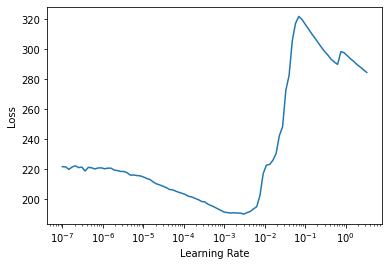

In [247]:
learn.lr_find()

In [248]:
learn.fit_one_cycle(10,0.0003)

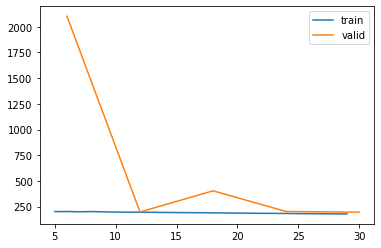

In [245]:
pd.DataFrame(learn.recorder.values,columns=['train_error','valid_error'])

In [249]:
learn.recorder.plot_loss()

,train_error,valid_error
0,203.536942,694.232544
1,195.945145,273.553925
2,185.051620,193.214264
3,175.122253,196.330185
4,166.379318,199.279007
5,158.597229,198.501450
6,151.053497,197.163284
7,144.309982,195.147614
8,138.477798,196.794739
9,133.587143,197.776962


In [250]:
preds,targs = learn.get_preds()

In [251]:
r_mse(preds,targs)

14.063319

In [ ]:
## Model - team based - similar opponents as training data
获取球队最近几场与相似对手交手时，取得的数据作为training data

相似对手：

1. 将ortg和drtg作为x轴y轴，几何距离最近的对手

1. 用什么的ortg，drtg？所有本赛季已进行的比赛的数据？单场？

In [ ]:
## Model - Player based

In [ ]:
# players? -> include minutes played
# injured players?
# use news to guess how many minutes he will play